In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Create Simulated Data ##

In [2]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

Plot the spikes and the position:

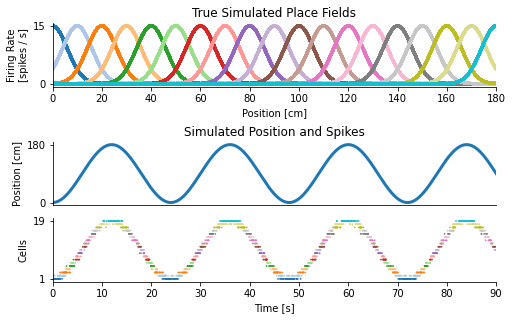

In [3]:
from replay_trajectory_classification.misc import TWO_COLUMN, GOLDEN_RATIO


spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(position, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('True Simulated Place Fields')
axes[0].set_xlim((position.min(), position.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])

axes[1].plot(time, position, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(position.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

### Fitting the Model ###

We can fit an encoding model by relating the position to the spikes (aka finding the place fields for each cell). Suppose we wanted to fit the animal's position while it is running.

First we use dask for parallelizing the fit.

In [4]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Client Scheduler: tcp://127.0.0.1:63265 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 34.36 GB


Then we can fit the model. Here we set the movement variance of the random walk (`movement_var`) to be the same as the animal's while running. `replay_speed` acts as a multiplier on the movement variance, so the ultimate variance of the Gaussian random walk is `movement_var` * `replay_speed`. We set the `place_bin_size`, which controls the discretization of position, to be the standard deviation of the movement variance. Finally we set `knot_spacing` to 10 cm. This controls the smoothness of the place field and corresponds to how fast you expect the firing rate to change over position.

In [5]:
from replay_trajectory_classification import SortedSpikesDecoder

from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)

decoder = SortedSpikesDecoder(movement_var=movement_var,
                              replay_speed=1,
                              place_bin_size=np.sqrt(movement_var),
                              knot_spacing=10)
decoder.fit(position, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...
/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/distributed/worker.py:3376: UserWarning: Large object of size 2.88 MB detected in task graph: 
  (array([0., 0., 0., ..., 0., 0., 0.]), 'ndarray-be ... 15434bf', 10.0)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=0.27758416432942346,
                    place_bin_size=0.5268625668325881, position_range=None,
                    replay_speed=1, spike_model_penalty=10.0,
                    transition_type='random_walk')

We can access the fitted place fields:

In [6]:
decoder.place_fields_

<xarray.DataArray (position: 342, neuron: 19)>
array([[0.01542895, 0.00369157, 0.00024556, ..., 0.00020195, 0.00020168,
        0.00016343],
       [0.01455643, 0.00418184, 0.00028232, ..., 0.00019986, 0.00019881,
        0.00016121],
       [0.0137245 , 0.00473188, 0.00032454, ..., 0.00019783, 0.00019602,
        0.00015905],
       ...,
       [0.00015676, 0.00018858, 0.00020046, ..., 0.00028063, 0.00443208,
        0.01360657],
       [0.00015885, 0.00019126, 0.00020257, ..., 0.00024204, 0.00394437,
        0.01406479],
       [0.00016099, 0.00019402, 0.00020473, ..., 0.00020872, 0.003507  ,
        0.01452619]])
Coordinates:
  * position  (position) float64 0.2632 0.7895 1.316 1.842 ... 178.7 179.2 179.7
Dimensions without coordinates: neuron

And plot them versus the true place fields:

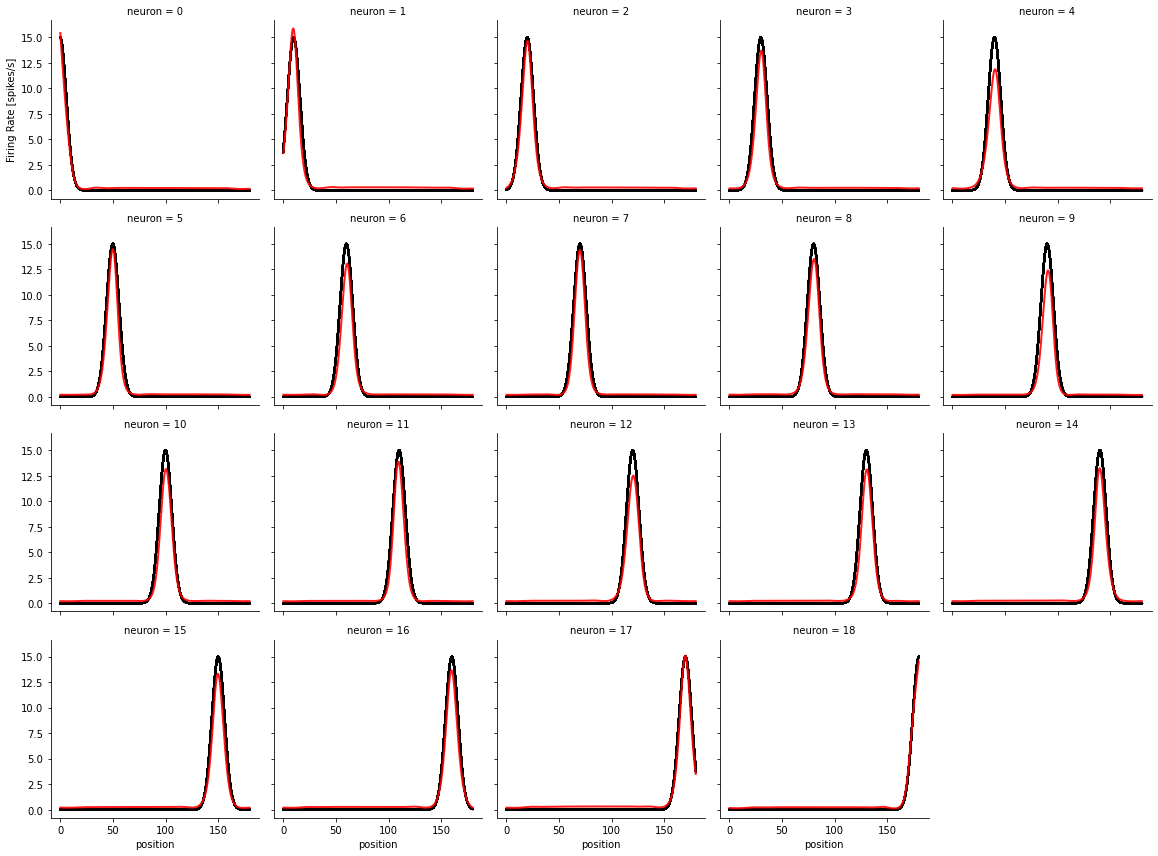

In [7]:
g = (decoder.place_fields_ * sampling_frequency).plot(
        x="position", col="neuron", col_wrap=5, color="red", linewidth=2, alpha=0.9, zorder=1, label="Predicted")
g.axes[0, 0].set_ylabel("Firing Rate [spikes/s]")
for ax, place_field in zip(g.axes.flat, place_fields.T):
    ax.plot(position, place_field, linewidth=2, color="black", zorder=-1, label="True")
sns.despine()

We can also plot the state transition model:

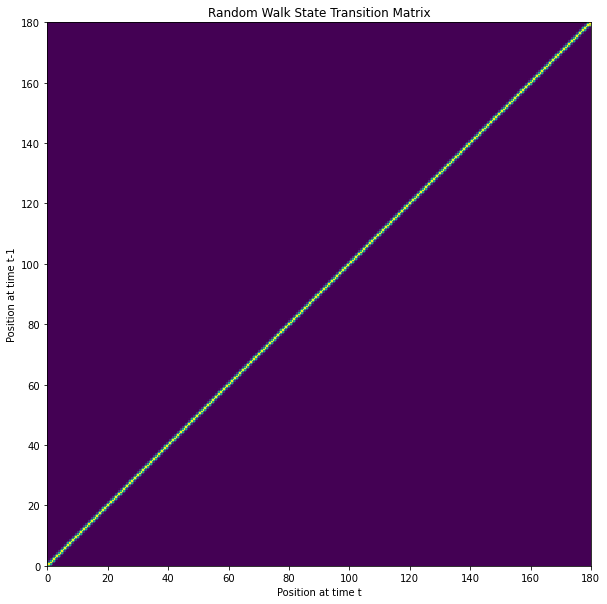

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

edge1, edge2 = np.meshgrid(decoder.place_bin_edges_, decoder.place_bin_edges_)
ax.pcolormesh(edge1, edge2, decoder.state_transition_.T, vmin=0.0, vmax=np.percentile(decoder.state_transition_, 99.9))
ax.set_title("Random Walk State Transition Matrix")
ax.set_ylabel("Position at time t-1")
ax.set_xlabel("Position at time t")
ax.axis("square");

## Predicting Position ##

We can predict the first 50,000 time bins, which produces an labeled array called `results`:

In [8]:
time_ind = slice(0, 50000)

results = decoder.predict(spikes[time_ind], time=time[time_ind])
results

<xarray.Dataset>
Dimensions:            (position: 342, time: 50000)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * position           (position) float64 0.2632 0.7895 1.316 ... 179.2 179.7
Data variables:
    likelihood         (time, position) float64 0.9972 0.9976 ... 0.9984 0.9983
    causal_posterior   (time, position) float64 0.002922 0.002924 ... 3.629e-57
    acausal_posterior  (time, position) float64 0.04841 0.06484 ... 3.629e-57

`results` has three main variables:
+ **likelihood** -- the probablility of spikes given position
+ **causal_posterior**: the probability of position given only past spikes
+ **acausal_posterior**: the probability of position given all past and future spikes

You'll probably want to use the **acausal_posterior**, but we can visualize both the acausal and causal and overlay the true position (magenta dashed line):

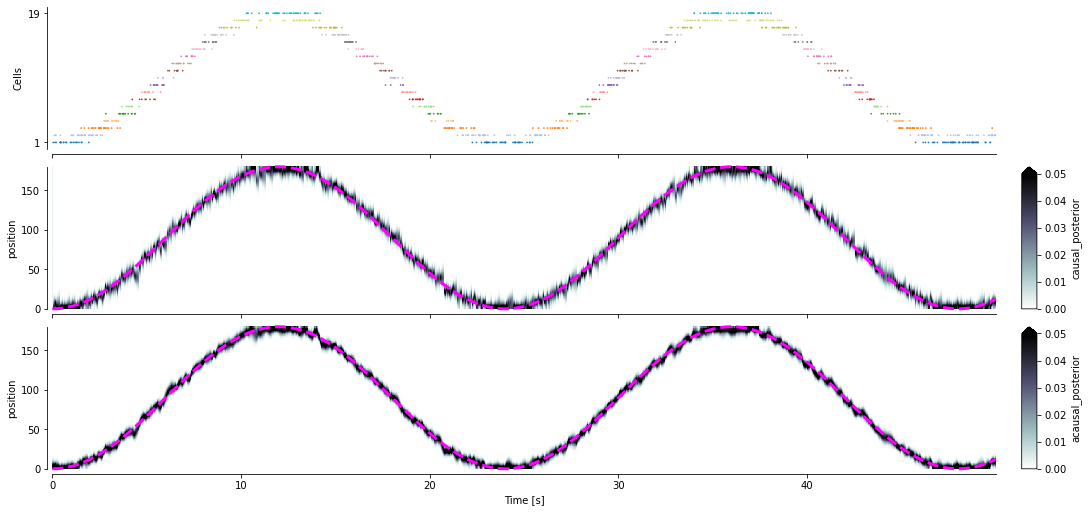

In [9]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

spike_ind, neuron_ind = np.nonzero(spikes[time_ind])
c = [cmap.colors[ind] for ind in neuron_ind]
axes[0].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5, clip_on=False)
axes[0].set_yticks((1, spikes.shape[1]))
axes[0].set_ylabel('Cells')

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)

From this, we can see, as expected, that the decoded position (given as a probability of position over time) matches the true position well.